<a href="https://colab.research.google.com/github/karank85/speech-recognition/blob/main/Copy_of_Project_2_Non_DL_Speech_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import os

import numpy as np
from numpy import ndarray
import pandas as pd

import librosa

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
from tqdm import tqdm


import glob
import torch

from pathlib import Path

In [83]:
librosa.__version__

'0.10.1'

In [84]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [85]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [86]:
# # Assumptions:
# # - The transcription file is located in the same directory as the audio files.
# class AudioDataset:
#   """
#   Class for loading and storing audio data.
#   """

#   def __init__(self):
#     self.df = pd.DataFrame(columns=['id', 'path', 'transcription'])

#   def load_transcriptions(self, directory_path: str) -> bool:
#     """
#     Load all transcriptions from a given directory, including subdirectories.
#     Returns False if no transcription files were found, or if any failed to load.
#     """
#     transcriptions_path = glob.glob(
#         f"{directory_path}/**/*.trans.txt",
#         recursive=True
#     )

#     if len(transcriptions_path) == 0:
#       return False

#     for path in transcriptions_path:
#       if not self.load_transcription_file(path):
#         return False

#     return True



#   def load_transcription_file(self, file_path: str) -> bool:
#     """
#     Parse transcription file and records the audio ID - subtitle mapping.
#     Returns False if the file could not be read.
#     """
#     with open(file_path, "r") as file:
#       file_directory = os.path.dirname(file_path)

#       lines = file.read().split("\n")
#       for line in lines:
#         if len(line.strip()) == 0:
#           continue
#         splitter = line.split(" ")
#         file_name = splitter[0]
#         file_content = ' '.join(splitter[1:])
#         self.df.loc[len(self.df)] = {
#             'id':file_name,
#             'transcription':file_content,
#             'path': f'{file_directory}/{file_name}.flac'
#         }
#       return True
#     return False

#   def keys(self):
#     return iter(self.df['id'])

#   def get(self, id: int):
#     """
#     Retrieve a dataframe row from ID.
#     """
#     return self.df.loc[self.df['id'] == id]

In [87]:
# Assumptions:
# - The transcription file is located in the same directory as the audio files.
class AudioDataset:
  """
  Class for loading and storing audio data.
  """

  def __init__(self):
    self.df = pd.DataFrame(columns=['id', 'path', 'transcription'])

  def load_transcriptions(self, directory_path: str) -> bool:
    """
    Load all transcriptions from a given directory, including subdirectories.
    Returns False if no transcription files were found, or if any failed to load.
    """
    sound_names = glob.glob(
        f"{directory_path}/**/*.wav",
        recursive=True
    )

    if len(sound_names) == 0:
      return False

    for path in sound_names:
      if not self.load_transcription_file(path):
        return False

    return True



  def load_transcription_file(self, file_path: str) -> bool:
    """
    Parse transcription file and records the audio ID - subtitle mapping.
    Returns False if the file could not be read.
    """

    file_directory = Path(file_path).parent
    file_name = Path(file_path).stem
    self.df.loc[len(self.df)] = {
        'id':file_name,
        'transcription':file_directory.name,
        'path': f'{file_directory}/{file_name}.wav'
    }
    return True

  def keys(self):
    return iter(self.df['id'])

  def get(self, id: int):
    """
    Retrieve a dataframe row from ID.
    """
    return self.df.loc[self.df['id'] == id]

In [88]:
ds = AudioDataset()

In [89]:
ds.load_transcriptions("/content/drive/MyDrive/test_hmm")

True

### Extracting Features

In [90]:
from librosa.feature import mfcc
import librosa
audio, sampling_freq = librosa.load(ds.df.head()['path'].values[0])
mfcc_features = librosa.feature.mfcc(sr=sampling_freq, y=audio)
print('\nNumber of windows =', mfcc_features.shape[0])
print('Length of each feature =', mfcc_features.shape[1])


Number of windows = 20
Length of each feature = 27


Text(0.5, 1.0, 'MFCC')

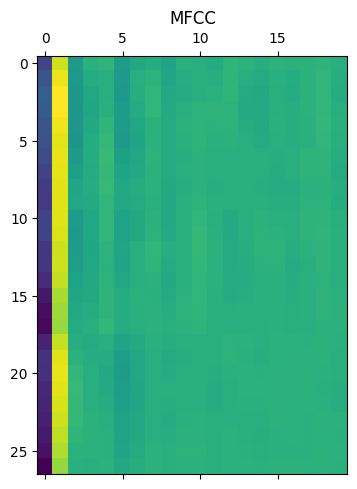

In [91]:
mfcc_features = mfcc_features.T
plt.matshow(mfcc_features)
plt.title('MFCC')

In [92]:
!pip install hmmlearn
!pip install features

In [93]:
import os
import numpy as np
from scipy.io import wavfile
from hmmlearn import hmm #importing GaussianHMM
import librosa # reading wavefilesfrom librosa.feature import mfcc #to extract mfcc features

In [94]:
class HMMTrainer(object):
  def __init__(self, model_name='GaussianHMM', n_components=4):
     self.model_name = model_name
     self.n_components = n_components

     self.models = []
     if self.model_name == 'GaussianHMM':
        self.model=hmm.GaussianHMM(n_components=4)
     else:
        print("Please choose GaussianHMM")

  def train(self, X):
      self.models.append(self.model.fit(X))

  def get_score(self, input_data):
      return self.model.score(input_data)

In [95]:
ds.df

,id,path,transcription
0,pineapple06,/content/drive/MyDrive/test_hmm/pineapple/pine...,pineapple
1,pineapple13,/content/drive/MyDrive/test_hmm/pineapple/pine...,pineapple
2,pineapple05,/content/drive/MyDrive/test_hmm/pineapple/pine...,pineapple
3,pineapple07,/content/drive/MyDrive/test_hmm/pineapple/pine...,pineapple
4,pineapple12,/content/drive/MyDrive/test_hmm/pineapple/pine...,pineapple
...,...,...,...
100,apple08,/content/drive/MyDrive/test_hmm/apple/apple08.wav,apple
101,apple02,/content/drive/MyDrive/test_hmm/apple/apple02.wav,apple
102,apple09,/content/drive/MyDrive/test_hmm/apple/apple09.wav,apple
103,apple03,/content/drive/MyDrive/test_hmm/apple/apple03.wav,apple


In [96]:
hmm_models = []
X = np.array([])

for index, row in ds.df.iloc[:-1, :].iterrows():
   # Read the input file
   audio, sampling_freq = librosa.load(row['path'])
   # Extract MFCC features
   mfcc_features = librosa.feature.mfcc(sr=sampling_freq, y=audio, n_mfcc=20)
   # Append to the variable X
   if len(X) == 0:
     X = mfcc_features[:, :15]  # 30 here denotes the number of MFCC coefficients to consider
   else:
     X = np.append(X, mfcc_features[:, :15], axis=0)
   # Append the label
  #  print('X.shape =', X.shape)

   # Train HMM model for this iteration
   hmm_trainer = HMMTrainer()
   hmm_trainer.train(X)  # Train using the current MFCC features
   hmm_models.append((hmm_trainer, row['transcription']))
   hmm_trainer = None


In [97]:
test = ds.df.iloc[-1,:]
# Read the input file
audio, sampling_freq = librosa.load(test['path'])
# Extract MFCC features
mfcc_features = librosa.feature.mfcc(sr=sampling_freq, y=audio)
X = mfcc_features[:, :15]
y_word = test['transcription']

In [98]:
scores = []
for hmm_model, _ in hmm_models:
    score = hmm_model.get_score(X)
    scores.append(score)

index = np.array(scores).argmax()
# Print the output
print("\nTrue:", y_word)
print("Predicted:", hmm_models[index][1])


True: apple
Predicted: kiwi
